# [NTDS'19] assignment 1: network science
[ntds'19]: https://github.com/mdeff/ntds_2019

[Eda Bayram](https://lts4.epfl.ch/bayram), [EPFL LTS4](https://lts4.epfl.ch) and
[Nikolaos Karalias](https://people.epfl.ch/nikolaos.karalias), [EPFL LTS2](https://lts2.epfl.ch).

## Students

* Team: `Team 7`
* Students: `Yeh, Chun-Hung` (for the indivudual submission) or `Guo, Jinhui; Hayakawa, Hiroki; Tung, Kuan; Yeh, Chun-Hung` (for the team submission)

## Rules

Grading:
* The first deadline is for individual submissions. The second deadline is for the team submission.
* All team members will receive the same grade based on the team solution submitted on the second deadline.
* As a fallback, a team can ask for individual grading. In that case, solutions submitted on the first deadline are graded.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

Submission:
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
  Note that Networkx is imported in the second section and cannot be used in the first.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter.

## Objective

The purpose of this milestone is to explore a given dataset, represent it by network by constructing different graphs. In the first section, you will analyze the network properties. In the second section, you will explore various network models and find out the network model fitting the ones you construct from the dataset.

## Cora Dataset

The [Cora dataset](https://linqs.soe.ucsc.edu/node/236) consists of scientific publications classified into one of seven research fields. 

* **Citation graph:** the citation network can be constructed from the connections given in the `cora.cites` file.
* **Feature graph:** each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary and its research field, given in the `cora.content` file. The dictionary consists of 1433 unique words. A feature graph can be constructed using the Euclidean distance between the feature vector of the publications.

The [`README`](data/cora/README) provides details about the content of [`cora.cites`](data/cora/cora.cites) and [`cora.content`](data/cora/cora.content).

## Section 1: Network Properties

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

### Question 1: Construct a Citation Graph and a Feature Graph

Read the `cora.content` file into a Pandas DataFrame by setting a header for the column names. Check the `README` file.

In [2]:
column_list = ['word_attributes.'+str(i+1) for i in range(1433)]
column_list.insert(0, 'paper_id')
column_list.append('class_label')
pd_content = pd.read_csv('data/cora/cora.content', delimiter='\t', names=column_list)
pd_content.head()

,paper_id,word_attributes.1,word_attributes.2,word_attributes.3,word_attributes.4,word_attributes.5,word_attributes.6,word_attributes.7,word_attributes.8,word_attributes.9,...,word_attributes.1425,word_attributes.1426,word_attributes.1427,word_attributes.1428,word_attributes.1429,word_attributes.1430,word_attributes.1431,word_attributes.1432,word_attributes.1433,class_label
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


Print out the number of papers contained in each of the reasearch fields.

**Hint:** You can use the `value_counts()` function.

In [3]:
num_papers = pd_content.class_label.value_counts()
num_papers

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: class_label, dtype: int64

Select all papers from a field of your choice and store their feature vectors into a NumPy array.
Check its shape.

In [4]:
my_field = pd_content[pd_content.class_label == 'Rule_Learning']
word_features = [i for i in my_field.columns if i.startswith('word')] 
features = my_field[word_features].values
features.shape

(180, 1433)

Let $D$ be the Euclidean distance matrix whose $(i,j)$ entry corresponds to the Euclidean distance between feature vectors $i$ and $j$.
Using the feature vectors of the papers from the field which you have selected, construct $D$ as a Numpy array. 

In [5]:
distance = np.zeros((features.shape[0], features.shape[0]))
for i in range(features.shape[0]): 
    for j in range(features.shape[0]):
        distance[i, j] = np.linalg.norm(features[i] - features[j])
distance.shape

(180, 180)

Check the mean pairwise distance $\mathbb{E}[D]$.

In [6]:
mean_distance = distance.mean()
mean_distance

5.822492039380866

Plot an histogram of the euclidean distances.

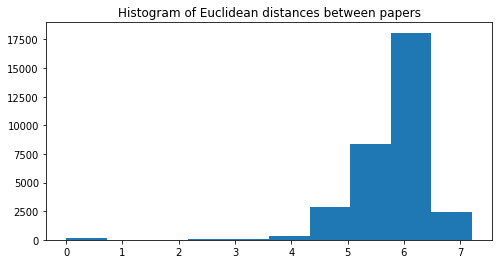

In [7]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of Euclidean distances between papers")
plt.hist(distance.flatten());

Now create an adjacency matrix for the papers by thresholding the Euclidean distance matrix.
The resulting (unweighted) adjacency matrix should have entries
$$ A_{ij} = \begin{cases} 1, \; \text{if} \; d(i,j)< \mathbb{E}[D], \; i \neq j, \\ 0, \; \text{otherwise.} \end{cases} $$

First, let us choose the mean distance as the threshold.

In [8]:
threshold = mean_distance
A_feature = np.where(distance < threshold, 1, 0)
np.fill_diagonal(A_feature, 0)

Now read the `cora.cites` file and construct the citation graph by converting the given citation connections into an adjacency matrix.

In [9]:
# Remap cited id and citing id to small value
cora_cites = np.genfromtxt('data/cora/cora.cites', delimiter='\t')
df_cora = pd.DataFrame({'cited_paper_id': cora_cites[:, 0], 'paper_id': cora_cites[:, 1]}).astype(int)
pd_content_2 = pd_content.copy()
pd_content_2.reset_index(level=0, inplace=True)
pd_content_2 = pd_content_2.rename(columns={'index':'node_idx'})
paperid2idx = pd_content_2[['node_idx', 'paper_id']]
paperid2idx = paperid2idx.set_index('paper_id')
paperid2idx.head()

,node_idx
paper_id,
31336,0
1061127,1
1106406,2
13195,3
37879,4


In [10]:
# Add a new column, matching the paper_id with the node_idx
df_cora = df_cora.join(paperid2idx, on='paper_id')

In [11]:
# Do the same with the cited_paper_uid
df_cora = df_cora.join(paperid2idx, on='cited_paper_id', rsuffix='_cited')

In [12]:
# Drop the paper_id and cited_paper_id
df_cora_renumbered = df_cora.drop(columns=['paper_id','cited_paper_id'])
df_cora_renumbered.head()

,node_idx,node_idx_cited
0,402,163
1,659,163
2,1696,163
3,2295,163
4,1274,163


In [13]:
num_papers = len(pd_content)
A_citation = np.zeros((num_papers, num_papers), dtype=int)

for idx, row in df_cora.iterrows():
    if np.isnan(row.node_idx_cited):
        continue
    i, j = int(row.node_idx), int(row.node_idx_cited)
    A_citation[i, j] = 1  # weight
    A_citation[j, i] = 1  # weight to obtain an undirected network
    
A_citation.shape

(2708, 2708)

In [14]:
np.sum(np.where(A_citation < 0, 1, 0))

0

Get the adjacency matrix of the citation graph for the field that you chose.
You have to appropriately reduce the adjacency matrix of the citation graph.

In [15]:
my_field_2 = my_field.copy().reset_index()
my_field_2.reset_index(level=0, inplace=True)
df_cora_2 = pd.DataFrame({'cited_paper_id': cora_cites[:, 0], 'paper_id': cora_cites[:, 1]}).astype(int)
my_field_2 = my_field_2.rename(columns={'level_0':'node_idx'})

paperid2idx = my_field_2[['node_idx', 'paper_id']]
paperid2idx = paperid2idx.set_index('paper_id')

df_cora_2 = df_cora_2.join(paperid2idx, on='paper_id')
df_cora_2 = df_cora_2.join(paperid2idx, on='cited_paper_id', rsuffix='_cited').dropna()

df_cora_renumbered_2 = df_cora_2.drop(columns=['paper_id','cited_paper_id'])

num_papers = len(my_field)
A_citation = np.zeros((num_papers, num_papers), dtype=int)

for idx, row in df_cora_2.iterrows():
    if np.isnan(row.node_idx_cited):
        continue
    i, j = int(row.node_idx), int(row.node_idx_cited)
    A_citation[i, j] = 1  # weight
    A_citation[j, i] = 1  # weight to obtain an undirected network

In [16]:
(A_citation.T == A_citation).all()

True

Check if your adjacency matrix is symmetric. Symmetrize your final adjacency matrix if it's not already symmetric.

In [17]:
np.count_nonzero(A_citation - A_citation.transpose())

0

Check the shape of your adjacency matrix again.

In [18]:
A_citation.shape

(180, 180)

### Question 2: Degree Distribution and Moments

What is the total number of edges in each graph?

In [19]:
num_edges_feature = int(np.count_nonzero(A_feature) / 2)
num_edges_citation = int(np.count_nonzero(A_citation) / 2)
print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Number of edges in the feature graph: 5829
Number of edges in the citation graph: 253


Plot the degree distribution histogram for each of the graphs.

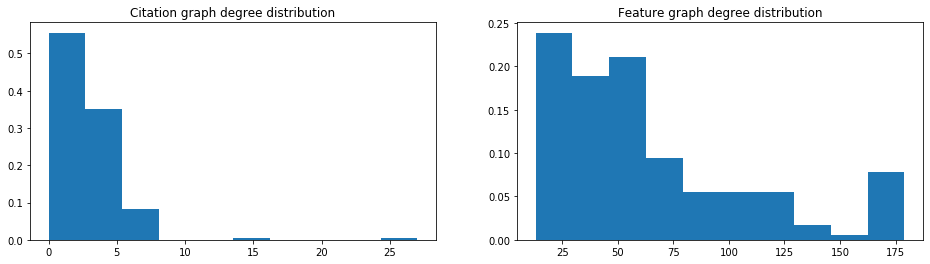

In [20]:
degrees_citation = np.sum(A_citation, axis = 1)
degrees_feature = np.sum(A_feature, axis = 1)
deg_hist_normalization = np.ones(degrees_citation.shape[0]) / degrees_citation.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title('Citation graph degree distribution')
axes[0].hist(degrees_citation, weights=deg_hist_normalization);
axes[1].set_title('Feature graph degree distribution')
axes[1].hist(degrees_feature, weights=deg_hist_normalization);

Calculate the first and second moments of the degree distribution of each graph.

In [21]:
cit_moment_1 = np.sum(np.sum(A_citation, axis = 1)) / len(A_citation)
cit_moment_2 = np.sum(np.square(np.sum(A_citation, axis = 1))) / len(A_citation)

feat_moment_1 = np.sum(np.sum(A_feature, axis = 1)) / len(A_feature)
feat_moment_2 = np.sum(np.square(np.sum(A_feature, axis = 1))) / len(A_feature)

print(f"1st moment of citation graph: {cit_moment_1}")
print(f"2nd moment of citation graph: {cit_moment_2}")
print(f"1st moment of feature graph: {feat_moment_1}")
print(f"2nd moment of feature graph: {feat_moment_2}")

1st moment of citation graph: 2.811111111111111
2nd moment of citation graph: 15.233333333333333
1st moment of feature graph: 64.76666666666667
2nd moment of feature graph: 6183.166666666667


What information do the moments provide you about the graphs?
Explain the differences in moments between graphs by comparing their degree distributions.

**Your answer here: 
Regarding 1st moment, we can see that 1st moment of the feature graph is way larger than the one of the citation graph. That is to say, the average degree of feature graph is much larger than the average degree of citation graph. From both of the distribution plots, it is easy to check that mean of the citation graph is smaller than the mean of feature graph. As for the 2nd moment, 2nd moment of feature graph is also extremely larger than 2nd moment of citation graph. From the distribution plots as well, the variance of feature graph is larger than the variance of citation graph since its distribution is widely spread but shrinked.**

Select the 20 largest hubs for each of the graphs and remove them. Observe the sparsity pattern of the adjacency matrices of the citation and feature graphs before and after such a reduction.

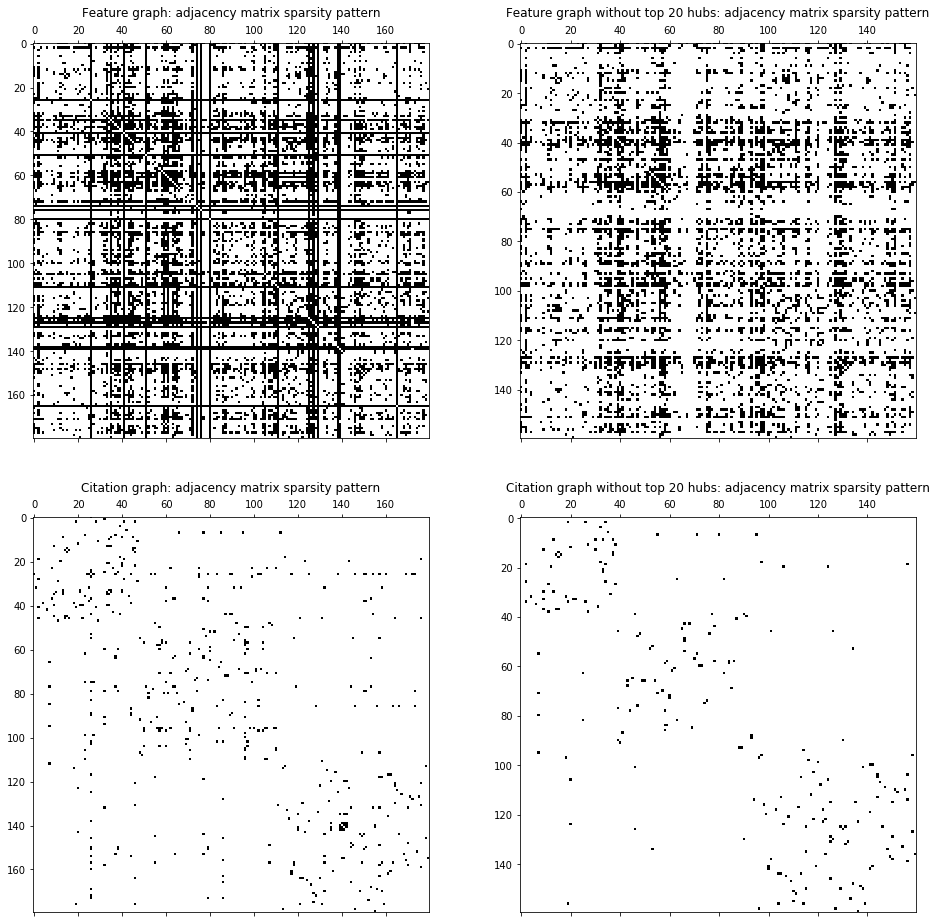

In [22]:
top_20_indx_feature = np.argsort(np.sum(A_feature, axis = 1))[-20:]
top_20_indx_citation = np.argsort(np.sum(A_citation, axis = 1))[-20:]

reduced_A_feature = np.delete(np.delete(A_feature, top_20_indx_feature, 0), top_20_indx_feature, 1)
reduced_A_citation = np.delete(np.delete(A_citation, top_20_indx_citation, 0), top_20_indx_citation, 1)

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes[0, 0].set_title('Feature graph: adjacency matrix sparsity pattern')
axes[0, 0].spy(A_feature);
axes[0, 1].set_title('Feature graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[0, 1].spy(reduced_A_feature);
axes[1, 0].set_title('Citation graph: adjacency matrix sparsity pattern')
axes[1, 0].spy(A_citation);
axes[1, 1].set_title('Citation graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[1, 1].spy(reduced_A_citation);

Plot the new degree distribution histograms.

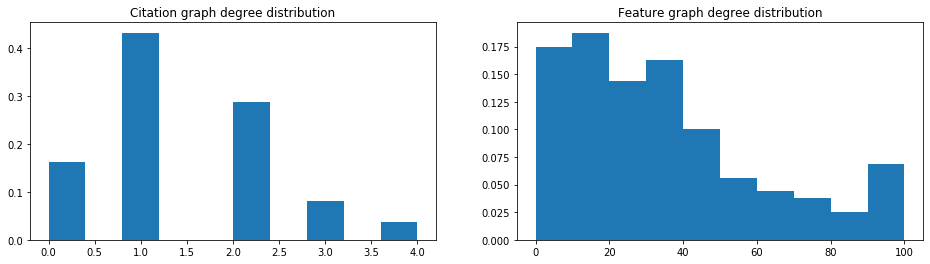

In [23]:
reduced_degrees_feat = np.sum(reduced_A_feature, axis = 1)
reduced_degrees_cit = np.sum(reduced_A_citation, axis = 1)

deg_hist_normalization = np.ones(reduced_degrees_feat.shape[0])/reduced_degrees_feat.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title('Citation graph degree distribution')
axes[0].hist(reduced_degrees_cit, weights=deg_hist_normalization);
axes[1].set_title('Feature graph degree distribution')
axes[1].hist(reduced_degrees_feat, weights=deg_hist_normalization);

Compute the first and second moments for the new graphs.

In [24]:
reduced_cit_moment_1 = np.sum(np.sum(reduced_A_citation, axis = 1)) / len(reduced_A_citation)
reduced_cit_moment_2 = np.sum(np.square(np.sum(reduced_A_citation, axis = 1))) / len(reduced_A_citation)

reduced_feat_moment_1 = np.sum(np.sum(reduced_A_feature, axis = 1)) / len(reduced_A_feature)
reduced_feat_moment_2 = np.sum(np.square(np.sum(reduced_A_feature, axis = 1))) / len(reduced_A_feature)


print("Citation graph first moment:", reduced_cit_moment_1)
print("Citation graph second moment:", reduced_cit_moment_2)
print("Feature graph first moment: ", reduced_feat_moment_1)
print("Feature graph second moment: ", reduced_feat_moment_2)

Citation graph first moment: 1.4
Citation graph second moment: 2.9125
Feature graph first moment:  34.1875
Feature graph second moment:  1870.2125


Print the number of edges in the reduced graphs.

In [25]:
num_edges_feature = int(np.count_nonzero(reduced_A_feature) / 2)
num_edges_citation = int(np.count_nonzero(reduced_A_citation) / 2)
print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Number of edges in the feature graph: 2735
Number of edges in the citation graph: 112


Is the effect of removing the hubs the same for both networks? Look at the percentage changes for each moment. Which of the moments is affected the most and in which graph? Explain why.  

**Hint:** Examine the degree distributions.

**Your answer here: No, removing the hubs leads to different results for both networks. Comparing the moments with and without hubs, we can see that second moment of citation graph is affected the most. Since rest of nodes are mostly linked to few nodes, taking away the hub from sparse citation graph results in most nodes only having low degree. This makes the variance of citation graph smaller after removing the hub.**

### Question 3: Pruning, sparsity, paths

By adjusting the threshold of the euclidean distance matrix, prune the feature graph so that its number of edges is roughly close (within a hundred edges) to the number of edges in the citation graph.

In [26]:
threshold = 2.78

A_feature_copy = distance.copy()
A_feature_pruned = np.where(A_feature_copy < threshold, 1, 0)
num_edges_feature_pruned = int(np.count_nonzero(A_feature_pruned) / 2)
np.fill_diagonal(A_feature_pruned, 0)

print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the feature graph after pruning: {num_edges_feature_pruned}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Number of edges in the feature graph: 2735
Number of edges in the feature graph after pruning: 114
Number of edges in the citation graph: 112


Check your results by comparing the sparsity patterns and total number of edges between the graphs.

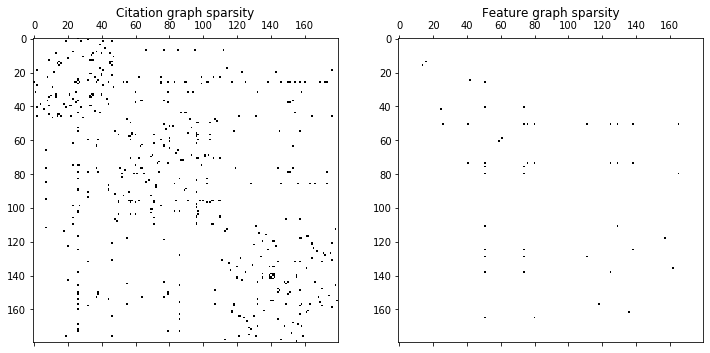

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('Citation graph sparsity')
axes[0].spy(A_citation);
axes[1].set_title('Feature graph sparsity')
axes[1].spy(A_feature_pruned);

Let $C_{k}(i,j)$ denote the number of paths of length $k$ from node $i$ to node $j$. 

We define the path matrix $P$, with entries
$ P_{ij} = \displaystyle\sum_{k=0}^{N}C_{k}(i,j). $

Calculate the path matrices for both the citation and the unpruned feature graphs for $N =10$.  

**Hint:** Use [powers of the adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix#Matrix_powers).

In [28]:
path_matrix_citation = np.zeros(A_citation.shape)
path_matrix_feature = np.zeros(A_feature.shape)

for i in np.arange(11):
    path_matrix_citation += np.linalg.matrix_power(A_citation, i)
    path_matrix_feature += np.linalg.matrix_power(A_feature, i)
    
path_matrix_citation

array([[1.066863e+06, 1.637230e+05, 0.000000e+00, ..., 0.000000e+00,
        1.394820e+05, 0.000000e+00],
       [1.637230e+05, 4.303300e+04, 0.000000e+00, ..., 0.000000e+00,
        2.694700e+04, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 6.662700e+04, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.394820e+05, 2.694700e+04, 0.000000e+00, ..., 0.000000e+00,
        4.965600e+04, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 6.535000e+03]])

In [29]:
path_matrix_feature

array([[2.16936866e+17, 1.04229182e+17, 2.40740763e+17, ...,
        1.92610691e+17, 7.67896564e+16, 5.68012988e+16],
       [1.04229182e+17, 5.00845992e+16, 1.15661842e+17, ...,
        9.25442090e+16, 3.68999237e+16, 2.72969645e+16],
       [2.40740763e+17, 1.15661842e+17, 2.67159290e+17, ...,
        2.13743654e+17, 8.52121798e+16, 6.30301926e+16],
       ...,
       [1.92610691e+17, 9.25442090e+16, 2.13743654e+17, ...,
        1.71013470e+17, 6.81811650e+16, 5.04344235e+16],
       [7.67896564e+16, 3.68999237e+16, 8.52121798e+16, ...,
        6.81811650e+16, 2.71861750e+16, 2.01113584e+16],
       [5.68012988e+16, 2.72969645e+16, 6.30301926e+16, ...,
        5.04344235e+16, 2.01113584e+16, 1.48783271e+16]])

Check the sparsity pattern for both of path matrices.

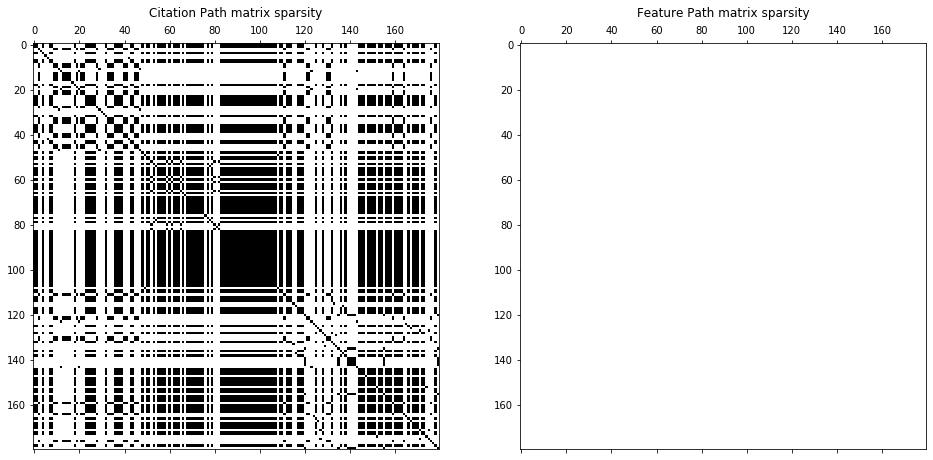

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9))
axes[0].set_title('Citation Path matrix sparsity')
axes[0].spy(path_matrix_citation);
axes[1].set_title('Feature Path matrix sparsity')
axes[1].spy(path_matrix_feature);

Now calculate the path matrix of the pruned feature graph for $N=10$. Plot the corresponding sparsity pattern. Is there any difference?

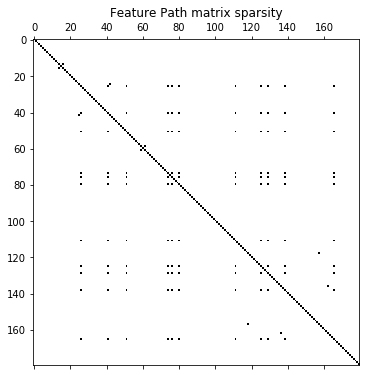

In [31]:
path_matrix_pruned = np.zeros(A_feature_pruned.shape)
for i in range(11):
    path_matrix_pruned += np.linalg.matrix_power(A_feature_pruned, i)

plt.figure(figsize=(12, 6))
plt.title('Feature Path matrix sparsity')
plt.spy(path_matrix_pruned);

**Your answer here: Yes, there are differences. The path matrix of the original feature graph has no zero in it, so there is no empty spot in the sparsity plot. But there are plenty of empty spots in the sparsity plot of the path matrix of the pruned feature graph for N = 10, which means the pruned feature graph has quite a few non-connected nodes.**

Describe how you can use the above process of counting paths to determine whether a graph is connected or not. Is the original (unpruned) feature graph connected?

**Your answer here: If there is no zero in the path matrix, then it is connected. For the original feature graph, there is no zero value in its corresponding path matrix, so the feature graph is indeed connected.** 

If the graph is connected, how can you guess its diameter using the path matrix?

**Your answer here: We can check the value of N when we increase N and see if there are any zeros in the path matrix.**

If any of your graphs is connected, calculate the diameter using that process.

In [32]:
path_matrix_feature = A_feature.copy()
for i in range(11):
    if np.count_nonzero(path_matrix_feature) == path_matrix_feature.shape[0] * path_matrix_feature.shape[1]:
        diameter = i + 1
        break
    path_matrix_feature += np.matmul(path_matrix_feature, A_feature)
print(f"The diameter is: {diameter}")

The diameter is: 2


Check if your guess was correct using [NetworkX](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.distance_measures.diameter.html).
Note: usage of NetworkX is only allowed in this part of Section 1.

In [33]:
import networkx as nx
feature_graph = nx.from_numpy_matrix(A_feature)
print(f"Diameter according to networkx: {nx.diameter(feature_graph)}")

Diameter according to networkx: 2


## Section 2: Network Models

In this section, you will analyze the feature and citation graphs you constructed in the previous section in terms of the network model types.
For this purpose, you can use the NetworkX libary imported below.

In [34]:
import networkx as nx

Let us create NetworkX graph objects from the adjacency matrices computed in the previous section.

In [35]:
G_citation = nx.from_numpy_matrix(A_citation)
print('Number of nodes: {}, Number of edges: {}'. format(G_citation.number_of_nodes(), G_citation.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_citation.number_of_selfloops(), nx.number_connected_components(G_citation)))

Number of nodes: 180, Number of edges: 253
Number of self-loops: 0, Number of connected components: 26


In the rest of this assignment, we will consider the pruned feature graph as the feature network.

In [36]:
G_feature = nx.from_numpy_matrix(A_feature_pruned)
print('Number of nodes: {}, Number of edges: {}'. format(G_feature.number_of_nodes(), G_feature.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_feature.number_of_selfloops(), nx.number_connected_components(G_feature)))

Number of nodes: 180, Number of edges: 24
Number of self-loops: 0, Number of connected components: 165


### Question 4: Simulation with Erdős–Rényi and Barabási–Albert models

Create an Erdős–Rényi and a Barabási–Albert graph using NetworkX to simulate the citation graph and the feature graph you have. When choosing parameters for the networks, take into account the number of vertices and edges of the original networks.

The number of nodes should exactly match the number of nodes in the original citation and feature graphs.

In [37]:
assert len(G_citation.nodes()) == len(G_feature.nodes())
n = len(G_citation.nodes())
n

180

The number of match shall fit the average of the number of edges in the citation and the feature graph.

In [38]:
m = np.round((G_citation.size() + G_feature.size()) / 2)
m

138.0

How do you determine the probability parameter for the Erdős–Rényi graph?

**Your answer here: In random networks, average degree of a node is equal to 2 times average link of a whole network divided by total number of nodes. Also, linking probability of a node to other is equal to average degree divided by (total number of nodes minus 1). Base on these formula, we can get the linking probability from the average link and total number of nodes.**

In [39]:
p = (2*m) / (n*(n-1))
G_er = nx.erdos_renyi_graph(n, p)

Check the number of edges in the Erdős–Rényi graph.

In [40]:
print('My Erdos-Rényi network that simulates the citation graph has {} edges.'.format(G_er.size()))

My Erdos-Rényi network that simulates the citation graph has 148 edges.


How do you determine the preferential attachment parameter for Barabási–Albert graphs?

**Your answer here: Since the average degree of Barabási-Albert graphs is equal to 2m, we decide m, the preferential attachment as average degree divided by 2.**

In [41]:
q = int(np.round(2*m/n/2) )
G_ba = nx.barabasi_albert_graph(n, q)

Check the number of edges in the Barabási–Albert graph.

In [42]:
print('My Barabási-Albert network that simulates the citation graph has {} edges.'.format(G_ba.size()))

My Barabási-Albert network that simulates the citation graph has 179 edges.


### Question 5: Giant Component

Check the size of the largest connected component in the citation and feature graphs.

In [43]:
giant_citation = max(nx.connected_component_subgraphs(G_citation), key=len)
print('The giant component of the citation graph has {} nodes and {} edges.'.format(giant_citation.number_of_nodes(), giant_citation.size()))

The giant component of the citation graph has 102 nodes and 172 edges.


In [44]:
giant_feature = max(nx.connected_component_subgraphs(G_feature), key=len)
print('The giant component of the feature graph has {} nodes and {} edges.'.format(giant_feature.number_of_nodes(), giant_feature.size()))

The giant component of the feature graph has 11 nodes and 19 edges.


Check the size of the giant components in the generated Erdős–Rényi graph.

In [45]:
giant_er = max(nx.connected_component_subgraphs(G_er), key=len)
print('The giant component of the Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er.number_of_nodes(), giant_er.size()))

The giant component of the Erdos-Rényi network has 132 nodes and 138 edges.


Let us match the number of nodes in the giant component of the feature graph by simulating a new Erdős–Rényi network.
How do you choose the probability parameter this time? 

**Hint:** Recall the expected giant component size from the lectures.

**Your answer here: From the lecture slides, fraction of giant component S is $$S = \frac{N_{G}}{N}$$
And logarithm of non-giant component fraction is $$\log{u} = - <k>(1-u)$$ So average degree $$<k>  = -\frac{\log{u}}{1-u}$$ Then probability parameter is $$p = \frac{<k>}{n-1}$$**

In [46]:
giant_component_fraction = giant_feature.number_of_nodes() / n
non_giant_component_fraction = 1 - giant_component_fraction
avg_degree = - (np.log(non_giant_component_fraction)) / giant_component_fraction
p_new = avg_degree / (n-1)
G_er_new = nx.erdos_renyi_graph(n, p_new)

Check the size of the new Erdős–Rényi network and its giant component.

In [47]:
print('My new Erdos Renyi network that simulates the citation graph has {} edges.'.format(G_er_new.size()))
giant_er_new = max(nx.connected_component_subgraphs(G_er_new), key=len)
print('The giant component of the new Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er_new.number_of_nodes(), giant_er_new.size()))

My new Erdos Renyi network that simulates the citation graph has 90 edges.
The giant component of the new Erdos-Rényi network has 36 nodes and 35 edges.


### Question 6: Degree Distributions

Recall the degree distribution of the citation and the feature graph.

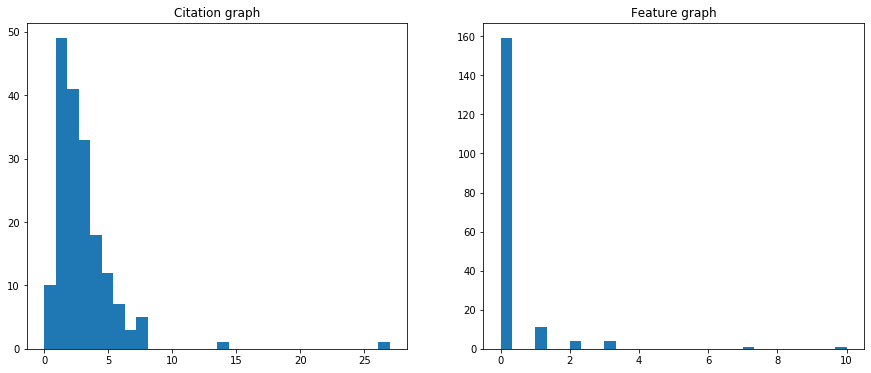

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].set_title('Citation graph')
citation_degrees = sorted([d for n, d in G_citation.degree()], reverse=True)
axes[0].hist(citation_degrees, bins = 30);
axes[1].set_title('Feature graph')
feature_degrees = sorted([d for n, d in G_feature.degree()], reverse=True)
axes[1].hist(feature_degrees, bins = 30);

What does the degree distribution tell us about a network? Can you make a prediction on the network model type of the citation and the feature graph by looking at their degree distributions?

**Your answer here: For a random network, its distribution is bionomial, or poisson if total number of nodes N is much greater than the average degree k; For a scale-free network, its distribution should follow power law, and the network may contain several hubs with higher degree. Therefore, if we predict citation graph, we think that it is more like a distribution of a random network, but feature graph is more like a scale-free network.**

Now, plot the degree distribution historgrams for the simulated networks.

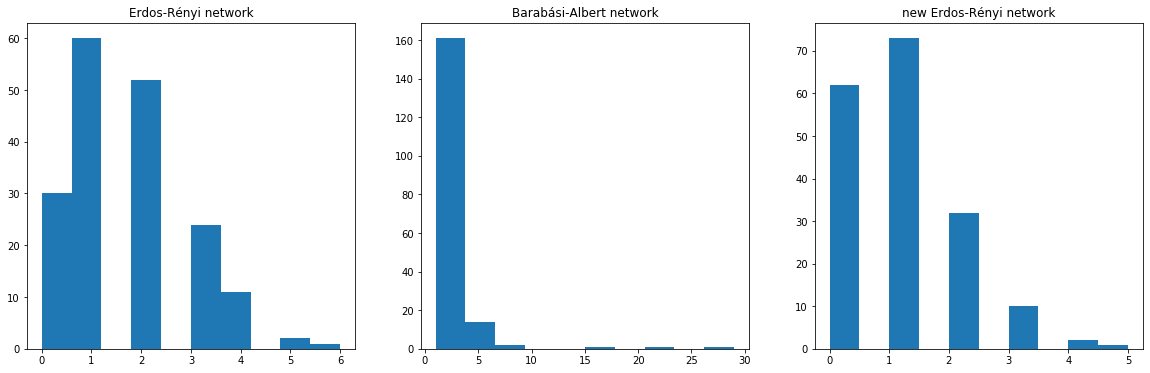

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].set_title('Erdos-Rényi network')
er_degrees = sorted([d for n, d in G_er.degree()], reverse=True)
axes[0].hist(er_degrees);
axes[1].set_title('Barabási-Albert network')
ba_degrees = sorted([d for n, d in G_ba.degree()], reverse=True)
axes[1].hist(ba_degrees);
axes[2].set_title('new Erdos-Rényi network')
er_new_degrees = sorted([d for n, d in G_er_new.degree()], reverse=True)
axes[2].hist(er_new_degrees);

In terms of the degree distribution, is there a good match between the citation and feature graphs and the simulated networks?
For the citation graph, choose one of the simulated networks above that match its degree distribution best. Indicate your preference below.

**Your answer here: Yes, we think that the distribution of feature graph would be much like Barabási-Albert network, heavily right skewed distribution. As stated in the previous question, we would say that the citation graph is more similar to a random network. Therefore, I would say that the citation graph matches with Erdos-Rényi network.** 

You can also simulate a network using the configuration model to match its degree disctribution exactly. Refer to [Configuration model](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html#networkx.generators.degree_seq.configuration_model).

Let us create another network to match the degree distribution of the feature graph. 

In [50]:
G_config = nx.configuration_model(feature_degrees) 
print('Configuration model has {} nodes and {} edges.'.format(G_config.number_of_nodes(), G_config.size()))

Configuration model has 180 nodes and 24 edges.


Does it mean that we create the same graph with the feature graph by the configuration model? If not, how do you understand that they are not the same?

**Your answer here: No, they are not the same. We can check whether the adjacency matrix of both models are equal or not.** 

### Question 7: Clustering Coefficient

Let us check the average clustering coefficient of the original citation and feature graphs. 

In [51]:
nx.average_clustering(G_citation)

0.26935863519196857

In [52]:
nx.average_clustering(G_feature)

0.0437037037037037

What does the clustering coefficient tell us about a network? Comment on the values you obtain for the citation and feature graph.

**Your answer here: A clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together. Regarding the citation graph, its clustering coefficient is small since it is random network alike. As for the feature graph, since it is more like scale-free network, the clustering coefficient decreases very fast as the number of nodes increases. As a result, its clustering coefficient is much smaller.**

Now, let us check the average clustering coefficient for the simulated networks.

In [53]:
nx.average_clustering(G_er)

0.012037037037037039

In [54]:
nx.average_clustering(G_ba)

0.0

In [55]:
nx.average_clustering(nx.Graph(G_config))

0.0023148148148148147

Comment on the values you obtain for the simulated networks. Is there any good match to the citation or feature graph in terms of clustering coefficient?

**Your answer here: No, the values are all too small compared to the values of citation graph and feature graph.**

Check the other [network model generators](https://networkx.github.io/documentation/networkx-1.10/reference/generators.html) provided by NetworkX. Which one do you predict to have a better match to the citation graph or the feature graph in terms of degree distribution and clustering coefficient at the same time? Justify your answer.

**Your answer here: I found the powerlaw cluster network could be a beeter match in terms of degree distribution and clustering coefficient. Because according to its document, it is essentially a Barabási–Albert (BA) growth model which is already a good match in terms of degree distribution. Also, it can approximate average clustering. We can let it approximate the average of the average clustering coefficient of citation graph and feature graph.**

If you find a better fit, create a graph object below for that network model. Print the number of edges and the average clustering coefficient. Plot the histogram of the degree distribution.

In [56]:
# Your code here.
G_plc = nx.powerlaw_cluster_graph(n, int(np.round((2 * m / n) / 2)), (nx.average_clustering(G_citation) + nx.average_clustering(G_feature)) / 2)

In [57]:
print('My powerlaw cluster network that simulates the citation graph has {} edges.'.format(G_plc.size()))
print('The average clustering coefficient of my powerlaw cluster network is {}.'.format(nx.average_clustering(G_plc)))

My powerlaw cluster network that simulates the citation graph has 179 edges.
The average clustering coefficient of my powerlaw cluster network is 0.0.


Text(0, 0.5, 'Frequency')

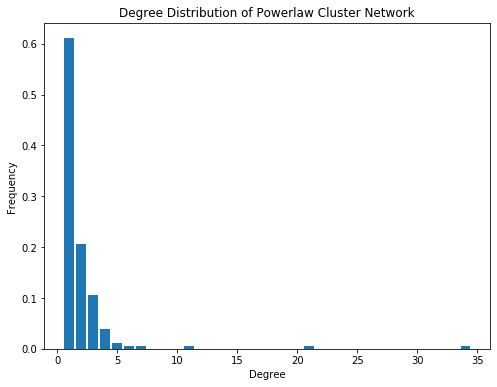

In [58]:
plc_degrees = sorted([d for n, d in G_plc.degree])
deg, cnt = np.unique(plc_degrees, return_counts=True)
plt.figure(figsize=(8, 6))
plt.bar(deg, cnt / sum(cnt));
plt.title('Degree Distribution of Powerlaw Cluster Network')
plt.xlabel('Degree')
plt.ylabel('Frequency')

Comment on the similarities of your match.

**Your answer here: The result meets my expectation. The number of edges, the average clustering coefficient and the degree distribution are a nice match to the citation graph and feature graph.**